In [1]:
import math

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Utility functions
def load_image(filename):
    src = cv2.imread(filename, cv2.IMREAD_COLOR)
    gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    return gray

def grating_fft(grating):
    ft = ifftshift(grating)
    ft = fft2(ft)
    ft = fftshift(ft)
    return ft

def image_fft(img):
    temp_array = np.array(img)
    return fftshift(fft2(temp_array))

def image_ifft(frequency_matrix):
    unshifted = fftshift(frequency_matrix)
    return ifft2(unshifted)

In [3]:
# Generates a sine wave at a 45degree angle w/ wavelength of
# 50pixels
def gen_512_noise(amp=256, angle=( -1 * np.pi / 4), w_len=50):
    x = np.arange(-256, 256, 1)
    X, Y = np.meshgrid(x, x)
    gratings = np.zeros(X.shape)
    gratings += (amp * np.sin(
        2 * np.pi * (X * np.cos(angle) + Y * np.sin(angle)) / w_len
    ))
    return gratings

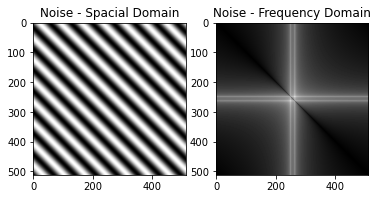

In [16]:
# Generate the noise to be used
noise1 = gen_512_noise(amp=100, w_len=50)
noise_fft = fftshift(fft2(noise1))
display_noise_fft = np.log(1 + abs(noise_fft))
plt.set_cmap("gray")
plt.subplot(121)
plt.title("Noise - Spacial Domain")
plt.imshow(noise1)
#plt.show()

plt.set_cmap("gray")
plt.subplot(122)
plt.title("Noise - Frequency Domain")
plt.imshow(display_noise_fft)
#plt.show()

<Figure size 432x288 with 0 Axes>

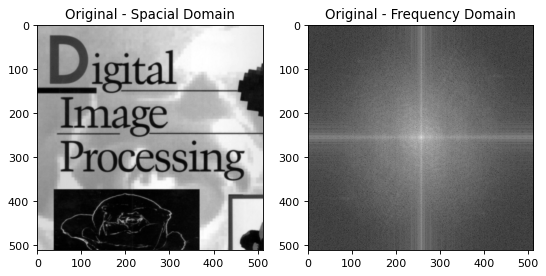

In [19]:
# Get the image and put it into the frequency domain
img_size = (512, 512)
img1 = load_image('DIPcover.bmp')
img1 = cv2.resize(img1, img_size, interpolation = cv2.INTER_AREA)

plt.set_cmap("gray")
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(121)
plt.title("Original - Spacial Domain")
plt.imshow(img1, cmap='gray');

FFT1 = image_fft(img1)
display_fft = np.log(1 + abs(FFT1))
#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.set_cmap("gray")
plt.subplot(122)
plt.title("Original - Frequency Domain")
plt.imshow(display_fft, cmap='gray');

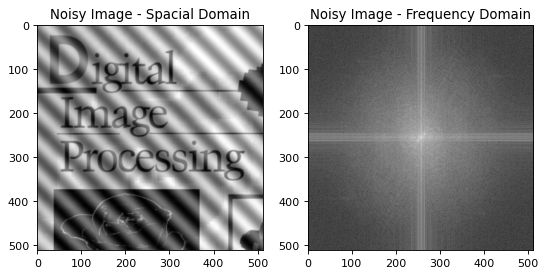

In [20]:
# Combine the image and the noise in the frequency domain
noisy_image = FFT1 + noise_fft
display_fft = np.log(1 + abs(noisy_image))
img_with_noise = image_ifft(noisy_image).real.astype(int)

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(121)
plt.title("Noisy Image - Spacial Domain")
plt.imshow(img_with_noise, cmap='gray')

#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(122)
plt.title("Noisy Image - Frequency Domain")
plt.imshow(display_fft, cmap='gray');

263 248
249 264


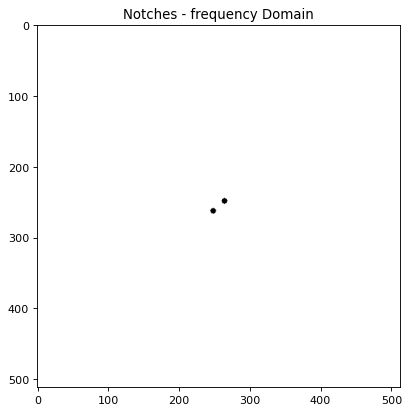

In [7]:
# Check the distance so that we can cut out circles
def distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def cut_notch(matrix, center_x, center_y, radius):
    for y in range(matrix.shape[1]):
        for x in range(matrix.shape[0]):
            if distance(center_x, center_y, x, y) <= radius:
                matrix[x,y] = 0
    return matrix

# Find the location of the min/max value and put notches there
# with the radius defined below
notches = np.ones((512, 512))
x1, y1 = np.unravel_index(np.argmin(noise_fft, axis=None),
                          noise_fft.shape)
x2 = 256 + (256 - x1)
y2 = 256 + (256 - y1)
print(x1, y1)
print(x2, y2)
radius = 4
notches = cut_notch(notches, x1, y1, radius)
notches = cut_notch(notches, x2, y2, radius)


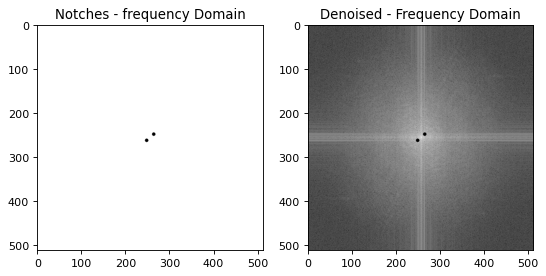

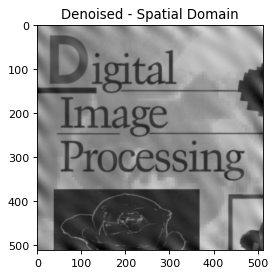

In [30]:
plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(121)
plt.title("Notches - frequency Domain")
plt.imshow(notches, cmap='gray');

# Apply the notch filter to the noisy image
filtered = noisy_image * notches
display_img_with_notches = np.log(1 + abs(filtered))
img_with_notches = image_ifft(filtered).real.astype(int)

#plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(122)
plt.title("Denoised - Frequency Domain")
plt.imshow(display_img_with_notches, cmap='gray');

plt.figure(num=None, figsize=(8, 6), dpi=80)
plt.subplot(121)
plt.title("Denoised - Spatial Domain")
plt.imshow(img_with_notches, cmap='gray');